In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
import os

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from pipeline.preprocessing import load_spacy_model
from pipeline.preprocessing.vectorize import EventVectoriser

# Data

In [4]:
# load data from file
datadir = os.path.join('data','events')  # change this if stored else

#filenames = [os.path.basename(file) for file in os.listdir(datadir)]  # get all files in path

filenames = ['events_high-conf.csv','events_medium-conf.csv','events_low-conf.csv']

filepaths = [os.path.join(datadir, filename) for filename in filenames]

In [5]:
# load specific spacy model
nlp = load_spacy_model(output_type='text', lemmatizer=True, geological_matcher=False, stopword_removal=False,
                       punctuation_removal=True, lemmatize_triggers=True, verbose=False)

# specify columns to load from data
usecols = ['event_id','filename','anumber','sentence_count','report_type','sentence_idx','sentence_triggers',
           'event_text','label','lower_idx','upper_idx']

# load dataframes into dictionary where key is filename
data = {filename : pd.read_csv(filepath, usecols=usecols) for filename, filepath in zip(filenames, filepaths)}

# pipe all datasets through nlp model to get text tokens
for filename in filenames:
    data[filename]['tokens'] = [tokens for tokens in tqdm(
        nlp.pipe(data[filename].event_text.values), desc=f'Tokenising {filename} text')]

# get class proportions for each labelled data set
def get_class_balances(data):
    class_balance = pd.concat([data[filename].label.value_counts().to_frame().rename(
        columns={'label':filename}).T for filename in data.keys()])

    return class_balance.div(class_balance.sum(axis=1), axis=0)

display(get_class_balances(data))

Tokenising events_high-conf.csv text: 1462it [00:30, 47.33it/s]
Tokenising events_medium-conf.csv text: 1462it [00:29, 49.14it/s]
Tokenising events_low-conf.csv text: 1462it [00:27, 52.74it/s]


False     True 
events_high-conf.csv    0.941860  0.058140
events_medium-conf.csv  0.857729  0.142271
events_low-conf.csv     0.780438  0.219562

# Vectorisation

In [6]:
# vectorisation settings to experiment with
vec_size = 20 # set number of dimensions for our numerical vectorisations by all methods
min_count = 1  # set minimum frequency for a word to be included in the training vocab, else remove

In [7]:
# vectorizers
vectorizers = {
    'doc2vec': EventVectoriser(num_workers=6, min_count=min_count, vec_size=vec_size),
    'lsa': Pipeline([
        ('tfidf', TfidfVectorizer(min_df=min_count, sublinear_tf=True)),
        ('svd', TruncatedSVD(n_components=vec_size))])
}

vectors = {
    key :  # for each data file
        { filename :   # for each type of vectoriser
         
             # doc2vec needs a pair of ids and list of tokenised strings - returns df by default
             vectorizer.fit_transform(data_df[['event_id','tokens']]) if key == 'doc2vec' else 
         
             # LSA needs a sentence as a string, but we tokenise first with spacy (data.tokens)
             pd.DataFrame(
                 vectorizer.fit_transform(data_df['tokens'].apply(lambda tokens : ' '.join(tokens).strip())),
                 index=data_df['event_id']
             )
            
        for filename, data_df in data.items()}
    for key, vectorizer in vectorizers.items()
}

# display preview of df
for v in vectorizers:
    for f in filenames:
        print(f'filename: {filename} vectorizer: {v}')
        display(vectors[v][f].head(3))
        print('')

filename: events_low-conf.csv vectorizer: doc2vec


0         1  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  3.406205 -1.749773   
a071875_700-100-go-rep-0002_13675165_172            1.859451  2.537405   
a071950_c591_1994_2005a_16001655_730               -0.876267 -4.212438   

                                                           2         3  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  3.395656 -1.646737   
a071875_700-100-go-rep-0002_13675165_172            0.927615 -0.933585   
a071950_c591_1994_2005a_16001655_730                2.632153 -2.259337   

                                                           4         5  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  2.024137  2.317167   
a071875_700-100-go-rep-0002_13675165_172           -0.048204  2.234170   
a071950_c591_1994_2005a_16001655_730                2.152080 -1.470653   

                                                           6         7  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -1.788769 -0.578341   
a071875_700-100-go-rep-0002_13675165_172            2.639422  0.684183   
a071950_c591_1994_2005a_16001655_730                0.263197 -2.119532   

                                                           8         9  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.578634 -2.091001   
a071875_700-100-go-rep-0002_13675165_172            2.372214 -4.101942   
a071950_c591_1994_2005a_16001655_730                5.244667 -1.813935   

                                                          10        11  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.653306  2.141947   
a071875_700-100-go-rep-0002_13675165_172           -2.264804 -2.484242   
a071950_c591_1994_2005a_16001655_730               -0.685774  4.178024   

                                                          12        13  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.014837 -0.420442   
a071875_700-100-go-rep-0002_13675165_172            1.604329 -2.696011   
a071950_c591_1994_2005a_16001655_730                3.686255 -0.726457   

                                                          14        15  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -1.740899  1.700975   
a071875_700-100-go-rep-0002_13675165_172            0.159590 -1.216970   
a071950_c591_1994_2005a_16001655_730               -1.755074 -2.416625   

                                                          16        17  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.256675  0.275776   
a071875_700-100-go-rep-0002_13675165_172           -1.542590 -2.149456   
a071950_c591_1994_2005a_16001655_730               -1.932409  0.876135   

                                                          18        19  
event_id                                                                
a071816_apollo 2005 annual tech report_11275634...  1.753995  0.801008  
a071875_700-100-go-rep-0002_13675165_172            3.479942 -0.658097  
a071950_c591_1994_2005a_16001655_730                0.663891 -2.067498


filename: events_low-conf.csv vectorizer: doc2vec


0         1  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  2.775020 -1.048743   
a071875_700-100-go-rep-0002_13675165_172            2.861502  0.665440   
a071950_c591_1994_2005a_16001655_730                0.131792 -5.205976   

                                                           2         3  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  4.962569  0.827874   
a071875_700-100-go-rep-0002_13675165_172            0.716084 -0.859310   
a071950_c591_1994_2005a_16001655_730                5.662729  0.498765   

                                                           4         5  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  1.174100  3.591609   
a071875_700-100-go-rep-0002_13675165_172            0.674938  3.033708   
a071950_c591_1994_2005a_16001655_730               -0.414425  1.964441   

                                                           6         7  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.429184 -0.609721   
a071875_700-100-go-rep-0002_13675165_172            3.399784 -0.138790   
a071950_c591_1994_2005a_16001655_730                1.479580 -2.985132   

                                                           8         9  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -2.359370 -2.509267   
a071875_700-100-go-rep-0002_13675165_172            2.126141 -1.132092   
a071950_c591_1994_2005a_16001655_730                3.018246 -1.603393   

                                                          10        11  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.942934  1.437100   
a071875_700-100-go-rep-0002_13675165_172           -2.088272 -0.855122   
a071950_c591_1994_2005a_16001655_730                1.586632  1.885387   

                                                          12        13  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.520481  0.539664   
a071875_700-100-go-rep-0002_13675165_172            3.258390  2.453758   
a071950_c591_1994_2005a_16001655_730                4.709718 -1.946175   

                                                          14        15  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -1.194636  0.573042   
a071875_700-100-go-rep-0002_13675165_172            0.203973 -1.969340   
a071950_c591_1994_2005a_16001655_730                1.242009 -3.450888   

                                                          16        17  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.640447  0.160475   
a071875_700-100-go-rep-0002_13675165_172           -1.102176 -3.946125   
a071950_c591_1994_2005a_16001655_730                0.915745 -0.459273   

                                                          18        19  
event_id                                                                
a071816_apollo 2005 annual tech report_11275634...  2.135026 -0.140436  
a071875_700-100-go-rep-0002_13675165_172            2.833153  0.566498  
a071950_c591_1994_2005a_16001655_730                1.670774 -1.945478


filename: events_low-conf.csv vectorizer: doc2vec


0         1  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  3.205954 -0.224131   
a071875_700-100-go-rep-0002_13675165_172            0.675300  1.324646   
a071950_c591_1994_2005a_16001655_730               -1.132850 -5.218374   

                                                           2         3  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  4.421660 -0.215710   
a071875_700-100-go-rep-0002_13675165_172            0.764901 -1.546813   
a071950_c591_1994_2005a_16001655_730                3.492912 -0.794011   

                                                           4         5  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  1.628967  0.881701   
a071875_700-100-go-rep-0002_13675165_172            0.262707  2.234934   
a071950_c591_1994_2005a_16001655_730               -0.593488 -1.213390   

                                                           6         7  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.246505 -1.139367   
a071875_700-100-go-rep-0002_13675165_172            4.708779  1.205412   
a071950_c591_1994_2005a_16001655_730                1.582966 -0.975659   

                                                           8         9  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -1.227064 -3.855987   
a071875_700-100-go-rep-0002_13675165_172            2.969622 -0.717251   
a071950_c591_1994_2005a_16001655_730                5.574703 -4.115663   

                                                          10        11  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.898605  0.912536   
a071875_700-100-go-rep-0002_13675165_172           -2.998199 -1.808228   
a071950_c591_1994_2005a_16001655_730                0.689109  2.860263   

                                                          12        13  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  1.026865 -0.540036   
a071875_700-100-go-rep-0002_13675165_172            0.447455  0.018114   
a071950_c591_1994_2005a_16001655_730                3.325472  1.782480   

                                                          14        15  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.357138 -0.070976   
a071875_700-100-go-rep-0002_13675165_172            1.796410 -1.421181   
a071950_c591_1994_2005a_16001655_730                1.602818 -2.175812   

                                                          16        17  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -1.124305 -0.602786   
a071875_700-100-go-rep-0002_13675165_172           -2.219769 -2.700044   
a071950_c591_1994_2005a_16001655_730               -0.126093 -0.589560   

                                                          18        19  
event_id                                                                
a071816_apollo 2005 annual tech report_11275634...  1.476382 -0.171029  
a071875_700-100-go-rep-0002_13675165_172            4.375125  0.136886  
a071950_c591_1994_2005a_16001655_730                0.240422 -1.155623


filename: events_low-conf.csv vectorizer: lsa


0         1  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.294510  0.039764   
a071875_700-100-go-rep-0002_13675165_172            0.266826 -0.038483   
a071950_c591_1994_2005a_16001655_730                0.229554  0.040758   

                                                           2         3  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.229310  0.003324   
a071875_700-100-go-rep-0002_13675165_172            0.027799 -0.026199   
a071950_c591_1994_2005a_16001655_730                0.025353 -0.156567   

                                                           4         5  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.069979  0.001994   
a071875_700-100-go-rep-0002_13675165_172            0.004119  0.027969   
a071950_c591_1994_2005a_16001655_730                0.109929  0.134249   

                                                           6         7  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.037119 -0.107562   
a071875_700-100-go-rep-0002_13675165_172           -0.029040 -0.126020   
a071950_c591_1994_2005a_16001655_730                0.028458  0.111678   

                                                           8         9  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.014692  0.001735   
a071875_700-100-go-rep-0002_13675165_172           -0.000051 -0.006559   
a071950_c591_1994_2005a_16001655_730               -0.054707 -0.058699   

                                                          10        11  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.077759  0.046288   
a071875_700-100-go-rep-0002_13675165_172            0.009065 -0.034482   
a071950_c591_1994_2005a_16001655_730                0.047933  0.052115   

                                                          12        13  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.010183  0.029617   
a071875_700-100-go-rep-0002_13675165_172            0.035647 -0.030340   
a071950_c591_1994_2005a_16001655_730                0.148032 -0.063253   

                                                          14        15  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.028531  0.004646   
a071875_700-100-go-rep-0002_13675165_172            0.066140  0.013712   
a071950_c591_1994_2005a_16001655_730                0.112266 -0.077598   

                                                          16        17  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.027762  0.082404   
a071875_700-100-go-rep-0002_13675165_172           -0.012384 -0.067399   
a071950_c591_1994_2005a_16001655_730               -0.015378  0.085010   

                                                          18        19  
event_id                                                                
a071816_apollo 2005 annual tech report_11275634... -0.015690  0.010608  
a071875_700-100-go-rep-0002_13675165_172           -0.006104  0.011545  
a071950_c591_1994_2005a_16001655_730               -0.062062  0.042778


filename: events_low-conf.csv vectorizer: lsa


0         1  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.297214  0.042046   
a071875_700-100-go-rep-0002_13675165_172            0.268971 -0.038517   
a071950_c591_1994_2005a_16001655_730                0.231564  0.045324   

                                                           2         3  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.228723  0.001446   
a071875_700-100-go-rep-0002_13675165_172            0.027327 -0.030060   
a071950_c591_1994_2005a_16001655_730                0.033000 -0.137828   

                                                           4         5  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.070835 -0.032672   
a071875_700-100-go-rep-0002_13675165_172            0.001924 -0.015747   
a071950_c591_1994_2005a_16001655_730                0.132166  0.001539   

                                                           6         7  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.008815 -0.105119   
a071875_700-100-go-rep-0002_13675165_172            0.022882 -0.134187   
a071950_c591_1994_2005a_16001655_730                0.145953  0.100857   

                                                           8         9  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.017451  0.070215   
a071875_700-100-go-rep-0002_13675165_172           -0.004709 -0.005953   
a071950_c591_1994_2005a_16001655_730               -0.053049  0.017945   

                                                          10        11  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.029307  0.041201   
a071875_700-100-go-rep-0002_13675165_172           -0.009315  0.004413   
a071950_c591_1994_2005a_16001655_730               -0.074528  0.061780   

                                                          12        13  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.028749 -0.045628   
a071875_700-100-go-rep-0002_13675165_172            0.004231  0.000147   
a071950_c591_1994_2005a_16001655_730                0.151740 -0.043173   

                                                          14        15  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.013767 -0.078980   
a071875_700-100-go-rep-0002_13675165_172            0.076193  0.033163   
a071950_c591_1994_2005a_16001655_730                0.053310  0.142576   

                                                          16        17  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.054890  0.043547   
a071875_700-100-go-rep-0002_13675165_172           -0.054114  0.007864   
a071950_c591_1994_2005a_16001655_730                0.070848  0.053111   

                                                          18        19  
event_id                                                                
a071816_apollo 2005 annual tech report_11275634... -0.007884  0.070156  
a071875_700-100-go-rep-0002_13675165_172            0.007472 -0.000128  
a071950_c591_1994_2005a_16001655_730                0.062041 -0.026851


filename: events_low-conf.csv vectorizer: lsa


0         1  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.300261  0.033804   
a071875_700-100-go-rep-0002_13675165_172            0.270276 -0.040465   
a071950_c591_1994_2005a_16001655_730                0.232644  0.047501   

                                                           2         3  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.237841 -0.006814   
a071875_700-100-go-rep-0002_13675165_172            0.022841 -0.025070   
a071950_c591_1994_2005a_16001655_730                0.029195 -0.112041   

                                                           4         5  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.078383 -0.035178   
a071875_700-100-go-rep-0002_13675165_172           -0.014739 -0.011387   
a071950_c591_1994_2005a_16001655_730               -0.133247  0.025860   

                                                           6         7  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.019909 -0.102995   
a071875_700-100-go-rep-0002_13675165_172            0.009008 -0.130743   
a071950_c591_1994_2005a_16001655_730                0.132082  0.093279   

                                                           8         9  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.046605  0.103391   
a071875_700-100-go-rep-0002_13675165_172           -0.005431  0.001479   
a071950_c591_1994_2005a_16001655_730               -0.082226  0.047123   

                                                          10        11  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.031755 -0.031774   
a071875_700-100-go-rep-0002_13675165_172            0.000236  0.003300   
a071950_c591_1994_2005a_16001655_730               -0.137682 -0.064966   

                                                          12        13  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634... -0.018414 -0.053861   
a071875_700-100-go-rep-0002_13675165_172           -0.009307  0.040481   
a071950_c591_1994_2005a_16001655_730                0.052977  0.097385   

                                                          14        15  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.063146  0.044429   
a071875_700-100-go-rep-0002_13675165_172           -0.051289  0.023084   
a071950_c591_1994_2005a_16001655_730               -0.077519  0.120366   

                                                          16        17  \
event_id                                                                 
a071816_apollo 2005 annual tech report_11275634...  0.009651  0.008088   
a071875_700-100-go-rep-0002_13675165_172            0.004979 -0.081783   
a071950_c591_1994_2005a_16001655_730                0.009451  0.063367   

                                                          18        19  
event_id                                                                
a071816_apollo 2005 annual tech report_11275634... -0.034444 -0.087492  
a071875_700-100-go-rep-0002_13675165_172            0.007077 -0.046640  
a071950_c591_1994_2005a_16001655_730               -0.025225 -0.009129

# Classification

## Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

# prepare dictionaries to store labels and ids for each data file
train_ids, train_labels, test_ids, test_labels = {}, {}, {}, {}

# for filename in data
for fn in data.keys():
    train_ids[fn], test_ids[fn], train_labels[fn], test_labels[fn] = train_test_split(
        data[fn].event_id, data[fn].label.to_frame().set_index(data[fn].event_id),
        test_size=0.2, stratify=data[fn].label, random_state=888)
    
# build train and test split
train = { method:  # train is a dictionary of vectors based on [method][filename] keys, and df values
    {filename : vector_df.loc[train_ids[filename].values]  # for each fil for each fn
     for filename, vector_df in vector_dfs.items()} # process each file's dataframe of word embeddings (vectors)
         for method, vector_dfs in vectors.items()}  # for each vectorisation method

# test is same as train code, but with the test_ids event_id strings for each file
test = { method: {filename : vector_df.loc[test_ids[filename].values]
    for filename, vector_df in vector_dfs.items()} for method, vector_dfs in vectors.items()}

# Specify Example Dataset for Classification

In [9]:
# example - model selection process should include all and store results in dataframe
example_dataset = 'events_medium-conf.csv'
df = data['events_medium-conf.csv']

X_train_vec = train['doc2vec'][example_dataset]
X_test_vec = test['doc2vec'][example_dataset]

y_train = train_labels[example_dataset].values.reshape(-1)
y_test = test_labels[example_dataset].values.reshape(-1)

## CosineMeanClassifier

In [10]:
from pipeline.classify import CosineMeanClassifier
from sklearn import metrics

In [11]:
cutoffs = np.linspace(0., 1.0, 201)
result_data = []

for cutoff in cutoffs:
    clf = CosineMeanClassifier(cutoff=cutoff)
    clf = clf.fit(train['doc2vec'][example_dataset])
    y_pred = clf.predict(test['doc2vec'][example_dataset])
    result_data.append({
        'accuracy': metrics.accuracy_score(test_labels[example_dataset], y_pred),
        'precision' : metrics.precision_score(test_labels[example_dataset], y_pred, zero_division=0),
        'recall' : metrics.recall_score(test_labels[example_dataset], y_pred, zero_division=0),
        'f_score' : metrics.f1_score(test_labels[example_dataset], y_pred, zero_division=0)
    })
    
results = pd.DataFrame(result_data, index=cutoffs)
results.plot(figsize=(14,10), title='CosineMeanClassifier metrics vs. Cut Off');

# Explainability with SHAP

In [12]:
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier  
from sklearn.svm import SVC
from yellowbrick.classifier import (
    classification_report, confusion_matrix, class_prediction_error, class_balance, roc_auc
)

In [13]:
model = VotingClassifier(estimators = [('XGB', XGBClassifier(nestimators=100, max_depth=2)),
                                        ('SVC', SVC(C=1, class_weight='balanced', gamma=0.1))],
                                        voting ='hard')

In [14]:
class_balance(y_train, y_test);

In [15]:
classification_report(model, X_train_vec, y_train, X_test_vec, y_test);

[17:59:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nestimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




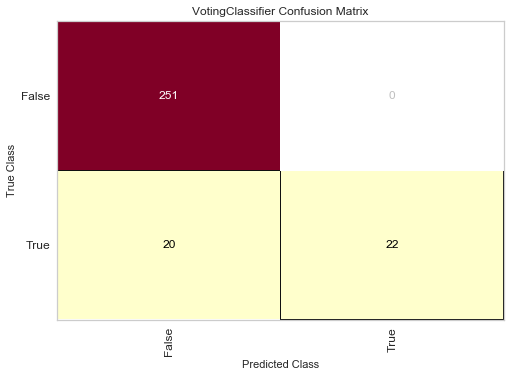

In [16]:
confusion_matrix(model, X_train_vec, y_train, X_test_vec, y_test);

In [17]:
class_prediction_error(model, X_train_vec, y_train, X_test_vec, y_test);

In [18]:
#roc_auc(model, X_train_vec, y_train, X_test_vec, y_test);

# TSNE visualization

In [19]:
# TSNE model for visualizations 

from sklearn.manifold import TSNE

tsne_model = TSNE(n_jobs=4,
                  perplexity = 500, #try different perplexity parameters
                  early_exaggeration=4, # Trying out exaggeration trick
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=500)


In [20]:
tsnedf = data['events_medium-conf.csv'][['filename','event_id','label', 'report_type', 'sentence_triggers', 'event_text']]
d2vvec = vectors['doc2vec']['events_medium-conf.csv']

In [21]:
tsne_d2v = tsne_model.fit_transform(d2vvec)

# Putting the tsne information into a dataframe
tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["Dim1", "Dim2"])

# add X values to full df
for col in ['filename','event_id','label', 'report_type', 'sentence_triggers', 'event_text']:
    tsne_d2v_df[col] = tsnedf[col].values

[t-SNE] Computing 1461 nearest neighbors...
[t-SNE] Indexed 1462 samples in 0.000s...
[t-SNE] Computed neighbors for 1462 samples in 0.530s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1462
[t-SNE] Computed conditional probabilities for sample 1462 / 1462
[t-SNE] Mean sigma: 3.948459
[t-SNE] KL divergence after 50 iterations with early exaggeration: 8.925064
[t-SNE] KL divergence after 500 iterations: 0.580249


In [22]:
import plotly.express as px
fig = px.scatter(tsne_d2v_df, x='Dim1', y='Dim2', 
                     height=600, width=600,
                     color = 'label', 
                 hover_name = 'filename', 
                hover_data = {'label': False, 
                              'Dim1': False,
                              'Dim2': False,
                              'report_type': True, 
                              'sentence_triggers': True,
                              'event_id': True, 
                             'event_text': False})
fig.update_layout(
    hoverlabel_align = 'left',
    title = 't-SNE Projection doc2vec ')

fig.show()